## Task 1: The images are 28 x 28 pixels in gray-scale. The categories are 0, 1, ... 9. Concatenate the image rows into a 28 x 28 vector and treat this as your feature, and assume the feature vectors in each category in the training data (”train-images-idx3-ubyte.gz”) have Gaussian distribution. Draw the mean and standard deivation of those features for the 10 categories as 28 x 28 images using the training images (”train-images-idx3-ubyte.gz”). There should be 2 images for each of the 10 digits, one for mean and one for standard deviation. We call those ”mean digits” and ”standard deviation digits”.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
train_img_file = 'Dataset/train-images.idx3-ubyte'
train_label_file = 'Dataset/train-labels.idx1-ubyte'
test_img_file = 'Dataset/t10k-images.idx3-ubyte'
test_label_file = 'Dataset/t10k-labels.idx1-ubyte'

In [4]:
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

convert(train_img_file, train_label_file, "Dataset/mnist_train.csv", 60000)
convert(test_img_file, test_label_file, "Dataset/mnist_test.csv", 10000)

#Reference: https://pjreddie.com/projects/mnist-in-csv/

In [5]:
train_data = np.loadtxt("Dataset/mnist_train.csv", delimiter=",")
test_data = np.loadtxt("Dataset/mnist_test.csv", delimiter=",")

In [6]:
# Reshaping them as a 2D Array

# train_imgs_2d = []
# test_imgs_2d = []
# for i in range(len(train_imgs)):
#     train_imgs_2d.append(np.reshape(train_imgs[i],(28,28)))
# for i in range(len(test_data)):
#     test_imgs_2d.append(np.reshape(test_data[i][1:],(28,28)))

In [7]:
# Key value pair for labels and all images
train_dataset = defaultdict(list)
for i in train_data:
    train_dataset[int(i[:1])].append(np.reshape(i[1:],(28,28)))
    
test_dataset = defaultdict(list)
for i in test_data:
    test_dataset[int(i[:1])].append(np.reshape(i[1:],(28,28)))

In [8]:
mean_digits = defaultdict(list)
for i in sorted(train_dataset):
    n = len(train_dataset[i])
    sum_img = [[0 for c in range(28)] for r in range(28)]
    for j in train_dataset[i]:
        sum_img += j
    mean_digits[i] = sum_img/n-1

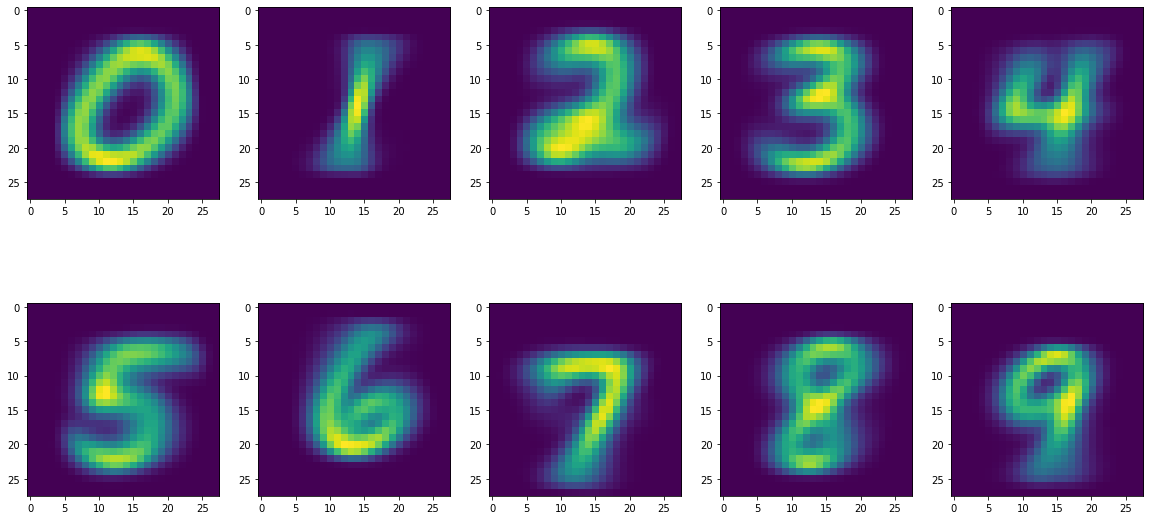

In [9]:
# Mean Digits
plt.figure(figsize=(20,10))
for i in range(0, len(mean_digits)):
    plt.subplot(2,5,i+1)
    plt.imshow(mean_digits[i])
plt.show()

In [10]:
standard_deviation_digits = defaultdict(list)
for i in sorted(train_dataset):
    n = len(train_dataset[i])
    sum_img = [[0 for c in range(28)] for r in range(28)]
    for j in train_dataset[i]:
        sum_img += np.power((j-mean_digits[i]),2)
    standard_deviation_digits[i] = np.sqrt(sum_img/(n-1))+1000

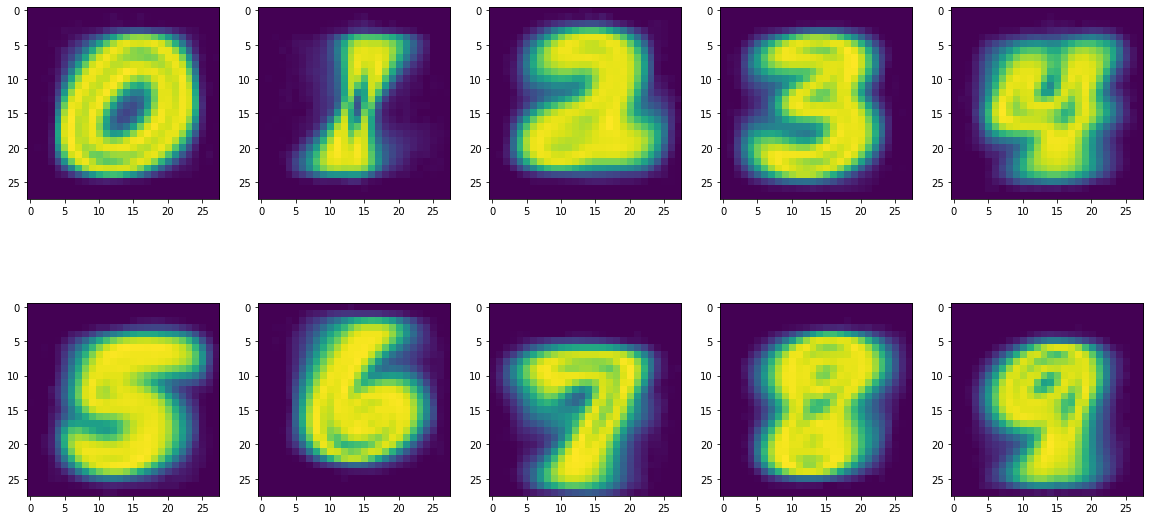

In [11]:
# Standard Deviation Digits
plt.figure(figsize=(20,10))
for i in range(0, len(standard_deviation_digits)):
    plt.subplot(2,5,i+1)
    plt.imshow(standard_deviation_digits[i])
plt.show()

## Task 2: Classify the images in the testing data set (”t10k-images-idx3-ubyte.gz”) using 0-1 loss function and Bayesian Decision Rule and report the performance. Before coding the discriminant functions, review Section 2.6 in textbook ”Pattern Classification by Richard O. Duda, Peter E. Hart and David G. Stork”. Answer the question: Why it doesn’t perform as good as many other methods on LeCun’s web page?

In [12]:
# Naive Bayes Probability Density Function

def calculate_probability(x, mean, stdev):
    diff = (x - mean)
    square = np.power(diff,2)
    divide = square/(2*stdev)
    exponent = np.exp(-divide)
    denominator = np.sqrt(2 * np.pi *stdev)
    pdf = exponent / denominator
    return pdf

In [34]:
#Split test dataset into images and labels

test_imgs = []
test_labels = []
for i in range(len(test_data)):
    test_imgs.append(np.reshape(test_data[i][1:],(28,28)))
    test_labels.append(test_data[i][:1])
classes = np.unique(test_labels)
nclasses = len(classes)
confusion_matrix = np.zeros([nclasses, nclasses])
classProbability = []
count = 0

In [35]:
# Assigning class probabilities P(class) for each digit in training data

for i in range(len(train_dataset)):
    classProbability.append(len(train_dataset[i])/len(train_data))

In [36]:
for i in range(len(test_imgs)):
    probabilities = []
    for j in range(nclasses):
        classProb = calculate_probability(test_imgs[i], mean_digits[j], standard_deviation_digits[j])
        ratio = np.sum(np.log(classProb)+np.log(classProbability[j]))
        probabilities.append(ratio)
    maxProb = max(probabilities) # Take Maximum probability of the class
    prediction = probabilities.index(maxProb)
    if prediction == test_labels[i]:
        count += 1
        confusion_matrix[int(test_labels[i])][int(test_labels[i])] = confusion_matrix[int(test_labels[i])][int(test_labels[i])]+1 #True Positives
    else:
        for k in range(nclasses):
            if prediction == k:
                confusion_matrix[int(test_labels[k])][int(test_labels[i])] = confusion_matrix[int(test_labels[k])][int(test_labels[i])]+1 #False Positives

#Reference: Taken code snippets for Naive Bayes Classifier - 
#https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/
#https://github.com/Arnab-0901/Classification-Algorithms/blob/master/Naive%20Bayes%20on%20MNIST.ipynb

In [37]:
# Testing the function with training data, (here testing it for digit 5)

# x = 3
# for i in range(0,10):
#     classProb = calculate_probability(train_dataset[i][0], mean_digits[x], standard_deviation_digits[x])
#     ratio = np.sum(np.log(classProb)+np.log(classProbability[x]))
#     print(ratio)

[Text(0.5, 69.0, 'Predictions'), Text(159.0, 0.5, 'Actual Values')]

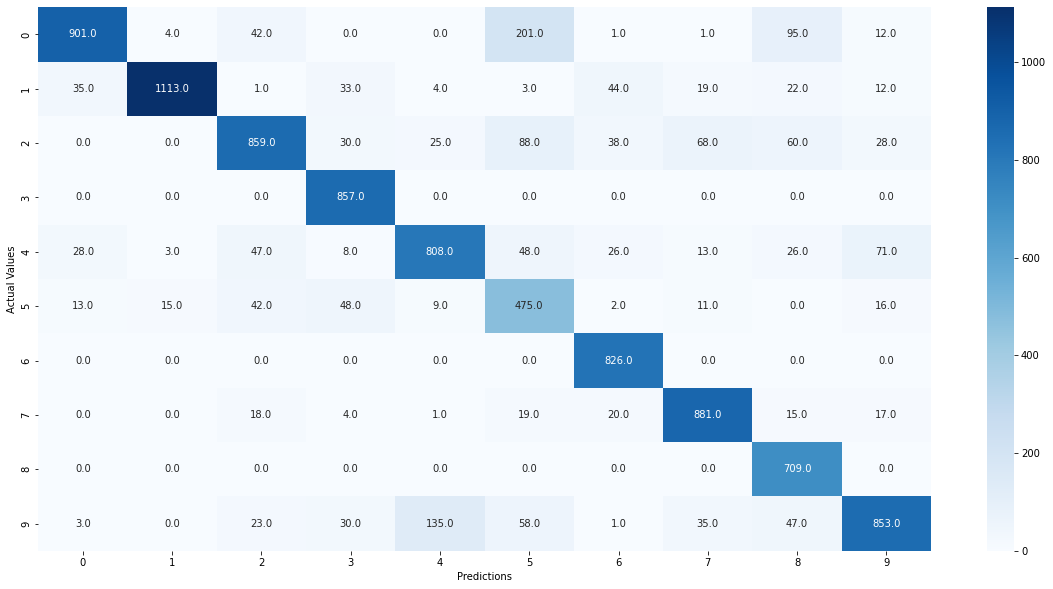

In [38]:
import seaborn as sns

# print(confusion_matrix)
plt.figure(figsize = (20,10))

sns.heatmap(confusion_matrix, annot=True, fmt='.1f', cmap='Blues').set(xlabel="Predictions", ylabel="Actual Values")

#Reference: https://stackoverflow.com/questions/64800003/seaborn-confusion-matrix-heatmap-2-color-schemes-correct-diagonal-vs-wrong-re

In [71]:
# Getting the TP,TN,FP,FN of each digit

true_positives = []
false_positives = []
false_negatives = []
true_negatives = []
tn_sum = 0
for i in range(nclasses):
    fp_sum = 0
    fn_sum = 0
    true_positives.append(confusion_matrix[int(i)][int(i)]) #Append individual true positives
    tn_sum += confusion_matrix[int(i)][int(i)]
    for j in range(nclasses):
        if i == j:
            continue
        fp_sum += confusion_matrix[int(j)][int(i)]
        fn_sum += confusion_matrix[int(i)][int(j)]
    false_positives.append(fp_sum) #Append individual false positives
    false_negatives.append(fn_sum) #Append individual false negatives
    
for i in range(nclasses):
    true_negatives.append(tn_sum - true_positives[i])

In [67]:
# Classification Accuracy = Correct Predictions/All existing images
overall_accuracy = count/len(test_imgs) * 100

In [75]:
# Getting the Precision, Recall and F1 score for each digit.
digit_accuracy = [0 for i in range(nclasses)]
digit_precision = [0 for i in range(nclasses)]
digit_recall = [0 for i in range(nclasses)]
digit_f1score = [0 for i in range(nclasses)]

for i in range(nclasses):
    digit_accuracy[i] = (true_positives[i]+true_negatives[i])/(true_positives[i]+false_positives[i]+true_negatives[i]+false_negatives[i])
    digit_precision[i] = true_positives[i]/(true_positives[i]+false_positives[i])
    digit_recall[i] = true_positives[i]/(true_positives[i]+false_negatives[i])
    digit_f1score[i] = 2 * ((digit_precision[i] * digit_recall[i])/(digit_precision[i] + digit_recall[i]))

In [76]:
print("Accuracy of the Naive Bayes Classifier: ",round(overall_accuracy,2),"%")

Accuracy of the Naive Bayes Classifier:  80.83 %


In [77]:
for i in range(nclasses):
    print("Digit:",i,", Accuracy:",round(digit_accuracy[i]*100,2),"%",", Precision:",round(digit_precision[i]*100,2),"%",", Recall:",round(digit_recall[i]*100,2),"%",", F1 Score:",round(digit_f1score[i]*100,2),"%")

Digit: 0 , Accuracy: 95.01 % , Precision: 91.94 % , Recall: 71.68 % , F1 Score: 80.55 %
Digit: 1 , Accuracy: 97.7 % , Precision: 98.06 % , Recall: 86.55 % , F1 Score: 91.95 %
Digit: 2 , Accuracy: 94.2 % , Precision: 83.24 % , Recall: 71.82 % , F1 Score: 77.11 %
Digit: 3 , Accuracy: 98.19 % , Precision: 84.85 % , Recall: 100.0 % , F1 Score: 91.81 %
Digit: 4 , Accuracy: 94.91 % , Precision: 82.28 % , Recall: 74.95 % , F1 Score: 78.45 %
Digit: 5 , Accuracy: 93.53 % , Precision: 53.25 % , Recall: 75.28 % , F1 Score: 62.38 %
Digit: 6 , Accuracy: 98.43 % , Precision: 86.22 % , Recall: 100.0 % , F1 Score: 92.6 %
Digit: 7 , Accuracy: 97.17 % , Precision: 85.7 % , Recall: 90.36 % , F1 Score: 87.97 %
Digit: 8 , Accuracy: 96.9 % , Precision: 72.79 % , Recall: 100.0 % , F1 Score: 84.25 %
Digit: 9 , Accuracy: 94.44 % , Precision: 84.54 % , Recall: 71.98 % , F1 Score: 77.76 %


### Why it doesn’t perform as good as many other methods on LeCun’s web page?
The reason this method does not perform as well as other methods is because Naive Bayes Classifier holds the assumption that features are independent upon one another. This leads to inaccuracies in terms of predictions. In reality, features do depend upon one another in minute amounts and contributes to one another in the classification confidence. Here, we take the highest probability of an image belonging to a particular digit class but this does not directly correlate to the classification confidence. The largest probability is close to 1 while others close to 0.

Reference:
##### https://www.quora.com/Why-is-naive-Bayes-a-decent-classifier-but-a-bad-estimator/answer/Ashkon-Farhangi
##### https://link.springer.com/content/pdf/10.1023/A:1007413511361.pdf

## Task 3: Construct the ”Fisher digits” from the MNIST data set according to Sections 3.8.2 and 3.8.3 in textbook ”Pattern Classification by Richard O. Duda, Peter E. Hart and David G. Stork”.

In [24]:
# Computing Within Class Differences:

sw = [[0 for c in range(28)] for r in range(28)]
for j in range(nclasses):
    n = len(train_dataset[j])
    for i in range(n):
        diff = mean_digits[j] - train_dataset[j][i]
        sw += np.dot(diff, np.transpose(diff))

In [25]:
# Total Mean of Dataset

mean_data = [[0 for c in range(28)] for r in range(28)]
for i in range(len(mean_digits)):
    mean_data += mean_digits[i]
mean_data /= len(mean_digits)

In [26]:
# Computing Between Class Differences:

sb = [[0 for c in range(28)] for r in range(28)]
for j in range(nclasses):
    diff = mean_digits[j] - mean_data
    sb += np.dot(diff, np.transpose(diff))

In [27]:
# Getting the Eigenvalues and Eigenvectors

M = np.dot(np.linalg.pinv(sw),sb)
eigvals,eigvecs = np.linalg.eig(M)
eiglist = [(eigvals[i],eigvecs[:,i]) for i in range(len(eigvals))]
eiglist = sorted(eiglist, key = lambda x: x[0], reverse = True)
w = eiglist[0][1] #Feature Vector

#Reference: https://ai.plainenglish.io/fischers-linear-discriminant-analysis-in-python-from-scratch-bbe480497504

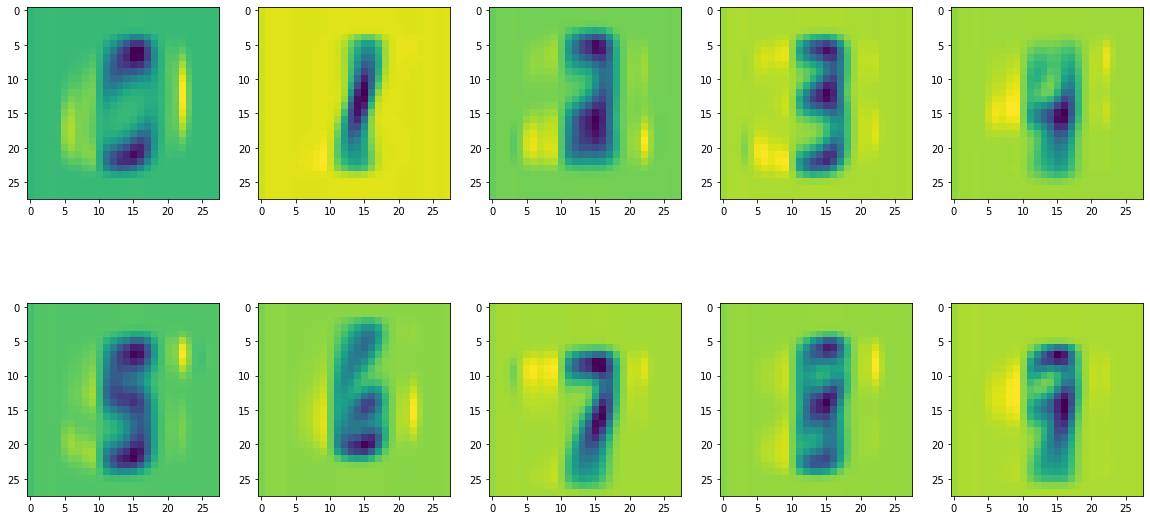

In [93]:
# Constructing the Fisher Digits 0-9:

plt.figure(figsize=(20,10))
for i in range(0, len(mean_digits)):
    plt.subplot(2,5,i+1)
    plt.imshow(w * mean_digits[i])
plt.show()